# Binary Model to Determine Above/Below-ground Pipelines
## From USDA Agriculture Aerial Photographs

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import geopandas as gpd
import matplotlib.pyplot as plt
import ee
import folium
import geemap.core as geemap
import geehydro
import math
import requests
import os
import skimage
import rasterio as rs
import time
from google.cloud import storage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn import svm, metrics, ensemble
from keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l2, l1
import keras
from keras import Sequential
from sklearn.preprocessing import LabelEncoder



In [2]:
def checkdirs(path):
    if not(os.path.exists(path)):
        os.makedirs(path)

In [20]:
def getImage(i):
    fname = f"pipeline{i}.tif"
    raw_filename = './images/'+fname
    BUCKET_NAME = 'test_export_bucket0' # change to 'gee_image_exports'
    # put service account key after from_service_account_json() if necessary
    # storage_client = storage.Client.from_service_account_json(r"C:\Users\toliv\Downloads\pipeline-elevation-project-cf69729f47df.json")
    raw_blobname = fname # change to f'USDA_aerials/{raw_filename}'
    checkdirs("./images")

    ## actually grab from cloud storage bucket
    # blob = storage_client.bucket(
#     BUCKET_NAME).blob(raw_blobname)
    blob = storage.Client(project="pipeline-elevation-project").bucket(
    BUCKET_NAME).blob(raw_blobname)
    start = time.time()
    blob.download_to_filename(raw_filename)
    end = time.time()
    print(f"Time taken for download:\n\t{end-start} seconds.")

    raster = rs.open(raw_filename)
    array = raster.read()
    dPic = np.dstack((array[0],array[1],array[2]))
    print(f"Got image {i}\n\twith shape {dPic.shape}")
    return dPic

### Import GeoTIFFs from Google Cloud Storage

In [28]:
## set up reference to GCS
#### should be loop, but for now...
def getGCPImage(i):
    fname = f"pipeline{i}.tif"
    raw_filename = './images/'+fname
    BUCKET_NAME = 'test_export_bucket0' # change to 'gee_image_exports'
    # put service account key after from_service_account_json() if necessary
    # storage_client = storage.Client.from_service_account_json(r"C:\Users\toliv\Downloads\pipeline-elevation-project-cf69729f47df.json")
    raw_blobname = fname # change to f'USDA_aerials/{raw_filename}'
    checkdirs("./images")

    ## actually grab from cloud storage bucket
    # blob = storage_client.bucket(
    #     BUCKET_NAME).blob(raw_blobname)
    blob = storage.Client(project="pipeline-elevation-project").bucket(
        BUCKET_NAME).blob(raw_blobname)
    start = time.time()
    blob.download_to_filename(raw_filename)
    end = time.time()
    print(f"Time taken for download:\n\t{end-start} seconds.")
    raster = rs.open(raw_filename)
    array = raster.read()
    GCPics = np.dstack((array[0],array[1],array[2]))
    print(f"Got image {i}\n\twith shape {GCPics.shape}")
    return GCPics

#### Giving a simple view to the tiff

In [18]:
raster = rs.open(raw_filename)
array = raster.read()


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [6]:
dPic = np.dstack((array[0],array[1],array[2]))
print(dPic.shape)
print(type(dPic))


(1680, 1464, 3)
<class 'numpy.ndarray'>


Time taken for download:
	1.6292457580566406 seconds.
Got image 1001
	with shape (1702, 1502, 3)
(256, 256, 3)


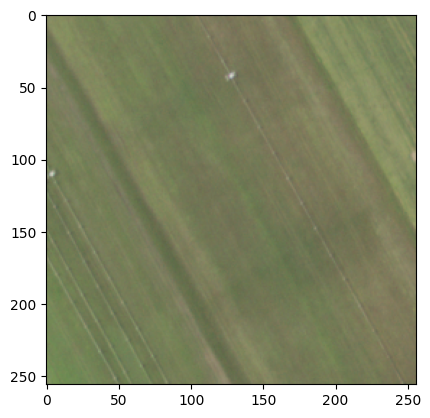

In [7]:
#Image Example

img=getImage(1001)
def crop(img):
    height, width = img.shape[0:2]
    new = 256

    left = int((width - new)/2)
    top = int((height - new)/2)
    right = int((width + new)/2)
    bottom = int((height + new)/2)

    # print(left,top,right,bottom)
    crop = img[top:bottom,left:right,:]
    print(crop.shape)
    return crop

plt.imshow(crop(img))


In [8]:
from PIL import Image
from matplotlib import cm
img=getImage(1001)
normImg = img/255
PILIMG = Image.fromarray(np.uint8(normImg)*255)
PILIMG.show()

Time taken for download:
	1.4686737060546875 seconds.
Got image 1001
	with shape (1702, 1502, 3)


In [35]:
plt.imshow(getGCPImage(1273), interpolation='nearest')

NotFound: 404 GET https://storage.googleapis.com/download/storage/v1/b/test_export_bucket0/o/pipeline1273.tif?alt=media: No such object: test_export_bucket0/pipeline1273.tif: ('Request failed with status code', 404, 'Expected one of', <HTTPStatus.OK: 200>, <HTTPStatus.PARTIAL_CONTENT: 206>)

4 Channels



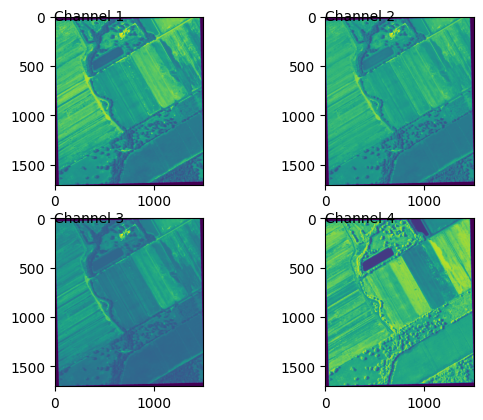

In [ ]:
print(len(array),end=" Channels\n\n")

squareDim = int(math.sqrt(len(array)))
fig, ax = plt.subplots(nrows = squareDim, ncols = squareDim)
for i in range(squareDim):
    for j in range(squareDim):
        ax[i,j].imshow(array[(i*2+j)])
        ax[i,j].text(-5.0,36.0,f"Channel {(i*2+j)+1}")
        
plt.show()


## After finishing operations, close raster

In [ ]:
## untested, might be safe to do after saving rs.read() to variable
rs.close()

AttributeError: module 'rasterio' has no attribute 'close'